In [1]:
#import all required libaries
from keras.datasets import cifar10 
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.models import Model, Sequential 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score

from keras.models import load_model 
from keras.losses import msle
import numpy as np # linear algebra
import matplotlib.pyplot as plt #visualization library

In [2]:
#load training and test dataset  from cifar10 dataset
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# Unit normalizing 
X_train = X_train.astype('float32')/255 
X_test = X_test.astype('float32')/255 
Y_test = Y_test.astype('float32')/255 
img_rows=X_train[0].shape[0]
img_cols=X_test[0].shape[1]
print(X_train.shape[0],img_rows,img_cols)
# Reshaping training and test datasets
X_train = X_train.reshape(len(X_train),X_train.shape[1],X_train.shape[2],3) 
# X_test = X_test.reshape(len(X_test),X_test.shape[1],X_test.shape[2],1) 
print(X_train.shape) #(50000, 32, 32, 3)
print(X_test.shape) #(10000, 32, 32, 3)
print(Y_test.shape) #(10000, 1)

170508288/170498071 [==============================] - 11s 0us/step
50000 32 32
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 1)


In [3]:
def build_autoencoder(img_shape):
    # The encoder network
    encoder = Sequential()
    encoder.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=img_shape)) # 32x32x32
    encoder.add(BatchNormalization()) # 32x32x32
    encoder.add(MaxPooling2D(2, padding='same')) # 16x16x32
    encoder.add(Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu'))  # 16x16x16
    encoder.add(BatchNormalization())  # 16x16x16
    encoder.add(Conv2D(8, kernel_size=3, strides=1, padding='same', activation='relu')) # 16x16x8
    encoder.add(BatchNormalization()) # 16x16x8
    encoder.add(Conv2D(8, kernel_size=3, strides=1, padding='same', activation='relu')) # 16x16x8
    
    # The decoder network
    decoder = Sequential()
    decoder.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')) # 16x16x32
    decoder.add(BatchNormalization()) # 16x16x32
    decoder.add(UpSampling2D()) # 32x32x32
    decoder.add(Conv2D(16, kernel_size=3, strides=2, padding='same', activation='relu')) # 16x16x16
    decoder.add(BatchNormalization()) # 16x16x16
    decoder.add(UpSampling2D()) # 32x32x16
    decoder.add(Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')) # 32x32x16
    decoder.add(BatchNormalization()) # 32x32x16
    decoder.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid')) # 32x32x3
    
    return encoder, decoder

In [4]:
# IMG_SHAPE =  X_train.shape[1:] #(32, 32, 3)
IMG_SHAPE =  X_train.shape[1:] 
input_img = Input(shape=IMG_SHAPE) #create image input
encoder, decoder = build_autoencoder(IMG_SHAPE)
code = encoder(input_img) #encode image
reconstruction = decoder(code) #decoder image
autoencoder = Model(input_img,reconstruction) #create autoencoder model
autoencoder.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error') # compile model using adam optimizer and measure loss using mean_squared_error
print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 16)       64        
 hNormalization)                                                 
                                                        

In [5]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=200)

In [6]:
# modelcheckpoint stores the weights best weights in a model with an interrval for futurue use
mc = ModelCheckpoint('auto_encoder_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [7]:
history = autoencoder.fit(x=X_train, y=X_train,
                validation_data=[X_test, X_test],  epochs=200, callbacks=[es, mc])
# history = autoencoder.fit(x=X_train, y=X_train,
#                 validation_data=[X_test, X_test], batch_size=32, epochs=100)

Epoch 1/200
1563/1563 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.6627
Epoch 1: val_accuracy improved from -inf to 0.74800, saving model to auto_encoder_model.h5
1563/1563 [==============================] - 21s 6ms/step - loss: 0.0054 - accuracy: 0.6627 - val_loss: 0.0025 - val_accuracy: 0.7480
Epoch 2/200
1559/1563 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 0.7855
Epoch 2: val_accuracy improved from 0.74800 to 0.80046, saving model to auto_encoder_model.h5
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0022 - accuracy: 0.7855 - val_loss: 0.0020 - val_accuracy: 0.8005
Epoch 3/200
1561/1563 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.8019
Epoch 3: val_accuracy improved from 0.80046 to 0.81010, saving model to auto_encoder_model.h5
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0018 - accuracy: 0.8019 - val_loss: 0.0011 - val_accuracy: 0.8101
Epoch 4/200
1563/1563 [=

In [8]:
# calculate the accuracy of the model
decoded_imgs = autoencoder.predict(X_test)
_, acc  = autoencoder.evaluate(decoded_imgs, X_test, steps=10)
print('> %.3f' % (acc * 100.0))

10/10 [==============================] - 1s 21ms/step - loss: 0.0011 - accuracy: 0.8188
> 81.877


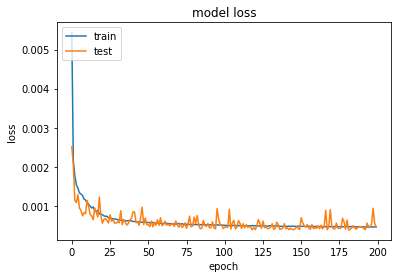

In [9]:
# plot loss vs val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

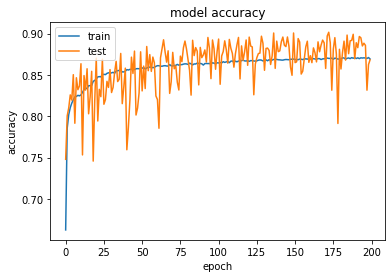

In [10]:
#accuracy between train and test data  based on training results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

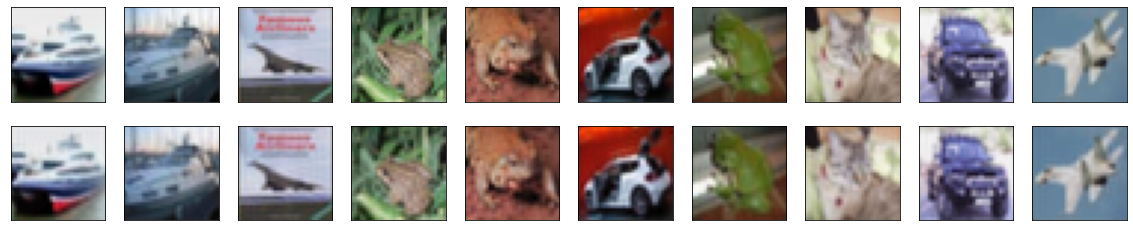

In [11]:
#for 10 results based on the model
decoded_imgs = autoencoder.predict(X_test) 
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
#find thershold
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold, reconstructions

In [13]:
threshold, reconstructions = find_threshold(autoencoder, X_train)

In [14]:
print(threshold)

0.0006083172


Measure quality of the reconstructed using different quality measurement techniques

In [15]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

In [16]:
def calculate_mse(imageA, imageB):
	return mse(imageA, imageB)

def calculate_psnr(imageA, imageB):
	return psnr(imageA, imageB)

def calculate_ssim(imageA, imageB):
	return ssim(imageA, imageB, multichannel=True)

def compression_ratio(original, compressed):
	return (original.size) / (compressed.size)

def compare_images(original, compressed, title):
	# compute the mean squared error, peak signal noise ratio and structural similarity
	fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True,sharey=True)
	ax = axes.ravel()
	cal_mse = calculate_mse(original,compressed)
	cal_psnr = calculate_psnr(original,compressed)
	cal_ssim = calculate_ssim(original,compressed)
	# setup the figure
	ax[0].imshow(original, cmap=plt.cm.gray)
	ax[0].set_xlabel(f'MSE: {calculate_mse(original,original):.4f}, SSIM: {calculate_ssim(original,original):.3f}')
	ax[0].set_title('Original image')

	ax[1].imshow(compressed, cmap=plt.cm.gray)
	ax[1].set_xlabel(f'MSE: {cal_mse:.4f}, PSNR: {cal_psnr:.3f}, SSIM: {cal_ssim:.3f}')
	ax[1].set_title('Compressed image')
  # plt.savefig("Compressed_{date}")
	plt.show()
  # plt.savefig("Compressed_{date}")

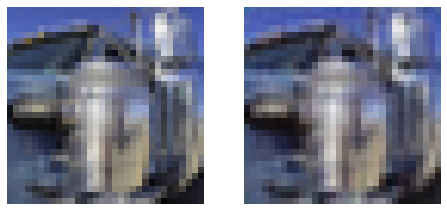

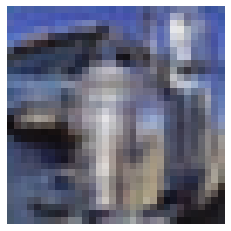

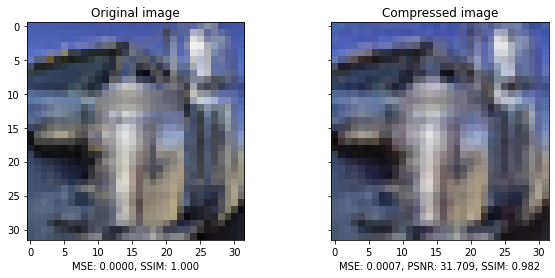

1.0000


In [17]:
# test quality results with random images
# initialize the figure
fig = plt.figure("Images",figsize=(12,10))
index  = np.random.randint(len(X_test))
original = np.squeeze(X_test[index])
compressed = np.squeeze(decoded_imgs[index])
images = ("Original", original), ("Reconstructed", compressed)
# loop over the images
for (i, (name, image)) in enumerate(images):
	# show the image

	ax = fig.add_subplot(1, 3, i + 1)
	# ax.set_title(name)
	plt.imshow(image, cmap = plt.cm.gray)
	plt.axis("off")
# show the figure
plt.show()

plt.imshow(original)
plt.axis('off')
# plt.title( "An 8x8 Image block")
plt.savefig("Original")

plt.imshow(compressed)
plt.axis('off')
# plt.title( "An 8x8 Image block")
plt.savefig("Reconstructed")

#compare image quality
compare_images(original, compressed, "Original vs. Reconstructed")

#calculate compression ratio
cr = "{:.4f}".format(compression_ratio(original, compressed))
print(cr)

Denoising Capability

In [18]:
# add some gaussian noise 
def apply_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

In [19]:
for i in range(30):
    print("Epoch %i/30, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)

    # We continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test])

Epoch 1/30, Generating corrupted samples...
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0022 - accuracy: 0.7695 - val_loss: 0.0025 - val_accuracy: 0.7828
Epoch 2/30, Generating corrupted samples...
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0021 - accuracy: 0.7755 - val_loss: 0.0021 - val_accuracy: 0.7872
Epoch 3/30, Generating corrupted samples...
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0021 - accuracy: 0.7767 - val_loss: 0.0021 - val_accuracy: 0.7763
Epoch 4/30, Generating corrupted samples...
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0021 - accuracy: 0.7770 - val_loss: 0.0020 - val_accuracy: 0.7928
Epoch 5/30, Generating corrupted samples...
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0021 - accuracy: 0.7777 - val_loss: 0.0020 - val_accuracy: 0.7823
Epoch 6/30, Generating corrupted samples...
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0020

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

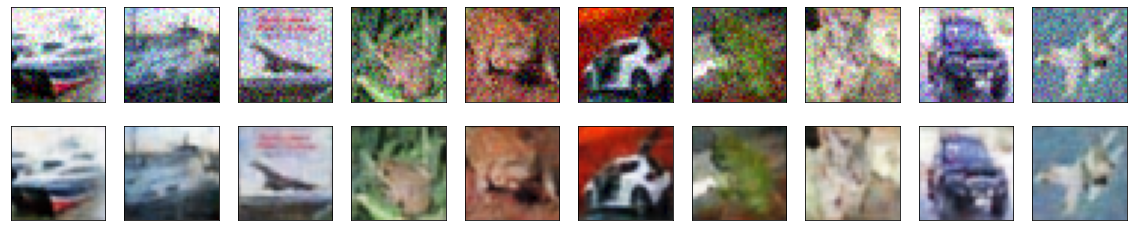

In [20]:
X_test_noise = apply_gaussian_noise(X_test)
n = 10
decoded_imgs = autoencoder.predict(X_test_noise)
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test_noise[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()